# Data preprocessing V: define channels as "contra-" and "ipsilateral" & calculate the CDA (difference wave)

As we are mostly interested in whether a channel was contra- or ipsilateral to the cued side of the memory array, we set up our data accordingly. By (our own) convention, we map all "contralateral" channels to the left hemisphere and "ipsilateral" channels to the right hemisphere. Channels on the midline stay untouched. Concretely, that means for trials with a cue pointing to the left, we swap the channel locations (i.e., for example, we treat the signal from `Fp1` as if it was coming from `Fp2` and v.v.). So in the following analyses, our data in channel "`Fp1`" actually represents data that was recorded in a channel contralateral to the cued side (and this will in ~50% of the cases have been `Fp2`). This facilitates data processing (and plotting) downstream and is quite common in the field. Basically, it is pooling across hemispheres, as we are expecting no relevant effects for the difference between hemispheres.  
The data after we flipped the channels according to this logic, we save with the tag `combined`.
Finally, we calculate (and save) the difference between the contra- and ipsilateral channels (ignoring the midline) and save it as `difference`. 

In [1]:
import os
import os.path as op
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mne
from pathlib import Path
from library import helpers, config

ModuleNotFoundError: No module named 'library'

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
                
sub_list = np.setdiff1d(np.arange(1,28), config.ids_missing_subjects + config.ids_excluded_subjects)
#sub_list = ['VME_S01']

for sub_nr in sub_list:
    subID = 'VME_S%02d' % sub_nr
    # subID = 'VME_S02'
    print(f'Running: {subID} ')
    for epo_part in ['cue', 'stimon', 'fulllength']:
        # Load data:
        fname = f'{subID}-{epo_part}-rejepo'
        path_in = op.join(config.paths['03_preproc-rejectET'], epo_part, 'cleaneddata')
        epochs = helpers.load_data(fname, path_in, '-epo', verbose=False)
        
        

        # Make dict summarizing chans in regions 'Left', 'Midline', 'Right'
        region_dict = mne.channels.make_1020_channel_selections(epochs.info)
        # Second dict that contains the (eeg!) channel names instead of their indexes:
        chnames_eeg = epochs.copy().pick_types(eeg=True).ch_names
        region_dict_chnames = dict()
        for k in region_dict.keys(): 
            region_dict_chnames[k] = [chnames_eeg[i] for i in region_dict[k]]
        
        # Define a dict that translates all lateralized channels to their 
        # counterpart on the other hemisphere:
        rename_dict_mirror = {k: v for k,v in zip(region_dict_chnames['Right'] + region_dict_chnames['Left'], 
                                                  region_dict_chnames['Left'] + region_dict_chnames['Right'])}

        # Define relevant events:
        event_dict = helpers.get_event_dict(epochs.event_id.keys())

        event_dict_rev = {epochs.event_id[k]: k for k in epochs.event_id} 
        idx_epos2flip = [event_dict_rev[idx] in event_dict['CueL'] for idx in epochs.events[:,2]]
        
        tmp = epochs.copy()._data
        for ch in rename_dict_mirror:
            idx_old = epochs.ch_names.index(ch)
            idx_new = epochs.ch_names.index(rename_dict_mirror[ch])
            tmp[idx_epos2flip, idx_new, :] = epochs._data[idx_epos2flip, idx_old, :]

        epos_collapsed = mne.EpochsArray(tmp,
                                         epochs.info,
                                         tmin=epochs.times[0],
                                         events=epochs.events,
                                         event_id=epochs.event_id,
                                         selection=epochs.selection,
                                         verbose=False)
        # Change sign of HEOG - so that by convention all eye movements to the "right" are now 
        # going to the stimulus:
        idx_heog = epos_collapsed.ch_names.index('HEOG') 
        epos_collapsed._data[idx_epos2flip,idx_heog,:] *= -1

        # Notice that: 
        #       Channels on the "right" are now "Ipsi-", chans on the left are "Contralateral" to 
        #       the cued stimulus. 

        for _dict in [region_dict, region_dict_chnames]:
            for n, o in zip(['Ipsi', 'Contra'], ['Right', 'Left']):
                _dict.update({n: _dict[o]})   

        # Now: Construct an epos object, that contains only the difference waves.
        # These will be stored in the channels over the left hemisphere.
        # Other channels will be dropped.
        epos_CDA = epos_collapsed.copy()
        _contra = epos_CDA.copy().pick_types(eeg=True).pick_channels(region_dict_chnames['Contra'], ordered=True)
        _ipsi = epos_CDA.copy().pick_types(eeg=True).pick_channels(region_dict_chnames['Ipsi'], ordered=True)
        # make sure that the channels are in the same order:
        assert _contra.ch_names == [rename_dict_mirror[k] for k in _ipsi.ch_names], 'Channel names are not identical'
        data_contra = _contra._data
        data_ipsi = _ipsi._data
        data_diff = data_contra - data_ipsi
        epos_CDA.pick_types(eeg=True).pick_channels(region_dict_chnames['Left'], ordered=True)
        # make sure that the channels are in the same order:
        assert epos_CDA.ch_names == _contra.ch_names
        epos_CDA._data = data_diff

        ## You can use this to visualize:

        # chans_CDA_dict = {'Left': ['P3', 'P5', 'PO3', 'PO7', 'O1'], 
        #                   'Right': ['P4', 'P6', 'PO4', 'PO8', 'O2']}
        # chans_CDA_all = [ch for v in list(chans_CDA_dict.values()) for ch in v]
        #  mne.viz.plot_compare_evokeds([epos_CDA[event_dict['LoadLow']].average(), epos_CDA[event_dict['LoadHigh']].average()], combine='mean', picks = chans_CDA_dict['Left'])

        path_out_collapsed = op.join(config.paths['03_preproc-pooled'], epo_part, 'collapsed')
        helpers.save_data(epos_collapsed, 
                          filename=f'{subID}-{epo_part}-collapsed', 
                          path=path_out_collapsed, 
                          append='-epo')

        path_out_diff = op.join(config.paths['03_preproc-pooled'], epo_part, 'difference')
        helpers.save_data(epos_CDA, 
                          filename=f'{subID}-{epo_part}-difference', 
                          path=path_out_diff,
                          append='-epo')
                        
    

Running: VME_S01 
Running: VME_S02 
Running: VME_S03 
Running: VME_S04 
Running: VME_S05 
Running: VME_S06 
Running: VME_S07 
Running: VME_S08 
Running: VME_S09 
Running: VME_S10 
Running: VME_S15 
Running: VME_S16 
Running: VME_S17 
Running: VME_S18 
Running: VME_S20 
Running: VME_S21 
Running: VME_S23 
Running: VME_S24 
Running: VME_S25 
Running: VME_S26 
Running: VME_S27 


combining channels using "mean"
combining channels using "mean"


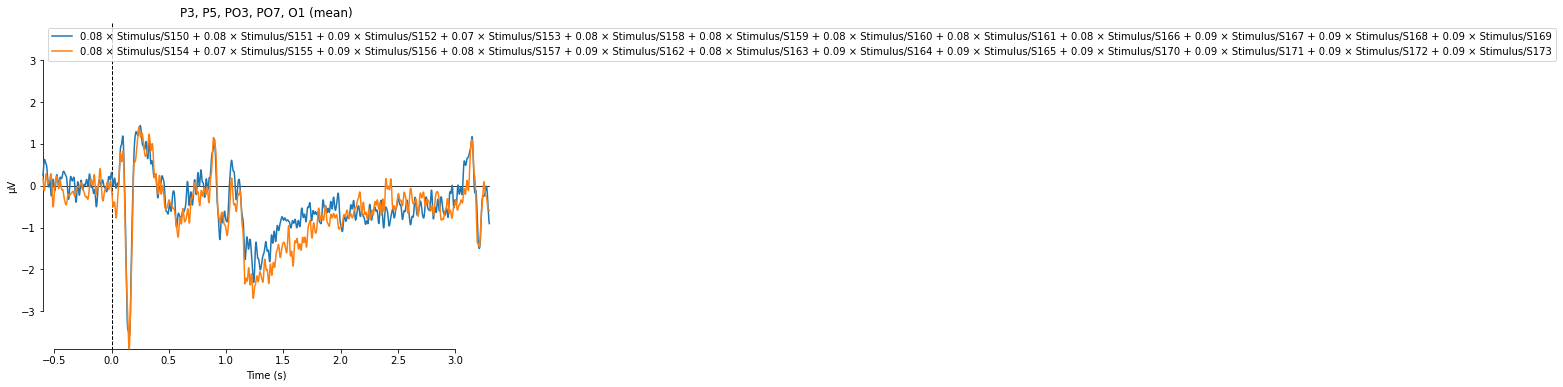

[<Figure size 576x432 with 1 Axes>]

In [10]:
        # You can use this to visualize:

        chans_CDA_dict = {'Left': ['P3', 'P5', 'PO3', 'PO7', 'O1'], 
                          'Right': ['P4', 'P6', 'PO4', 'PO8', 'O2']}
        chans_CDA_all = [ch for v in list(chans_CDA_dict.values()) for ch in v]
        mne.viz.plot_compare_evokeds([epos_CDA[event_dict['LoadLow']].average(), epos_CDA[event_dict['LoadHigh']].average()], combine='mean', picks = chans_CDA_dict['Left'])

In [6]:
## test:

subID = 'VME_S13'
epo_part = 'fulllength'
fname_pre = f'{subID}-{epo_part}-rejepo'
fname_post = f'{subID}-{epo_part}-collapsed'
path_in = op.join(config.paths['03_preproc-rejectET'], epo_part, 'cleaneddata')
path_out = op.join(config.paths['03_preproc-pooled'], epo_part, 'collapsed')
data_pre = helpers.load_data(fname_pre, path_in, '-epo', verbose=False)
data_post = helpers.load_data(fname_post, path_out, '-epo', verbose=False)

In [7]:
comp_chans = [('Fp1', 'Fp2'), ('PO4', 'PO3'), ('Cz', 'Cz'), ('TP9', 'TP10')]

for cc in comp_chans:
    data_contra_pre = data_pre.copy().pick_channels([cc[1]])[config.event_dict['CueL']].get_data()
    data_ipsi_post = data_post.copy().pick_channels([cc[0]])[config.event_dict['CueL']].get_data()
    np.testing.assert_array_equal(data_contra_pre, data_ipsi_post)
    data_contra_pre = data_pre.copy().pick_channels([cc[1]])[config.event_dict['CueR']].get_data()
    data_ipsi_post = data_post.copy().pick_channels([cc[1]])[config.event_dict['CueR']].get_data()
    

np.all(data_pre.selection == data_post.selection)

True